# PCA / LSA on text data and some clustering

In this notebook, I will be using the 20 Newsgroups dataset to show how you can apply some of the techniques we've learned in lessons on text data. This notebook is still a work in progress, so I apologise for any improper formatting or non-PEP8 code. Reach out to me if you have any questions, feedback or spot glaring errors.

In [20]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from sklearn.linear_model import LogisticRegression
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import silhouette_score
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ipreoteasa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ipreoteasa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ipreoteasa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Extract, Transform and Load our text data

In [2]:
from sklearn.datasets import fetch_20newsgroups

In [3]:
X_train, y_train = fetch_20newsgroups(subset='train', return_X_y=True)
X_test, y_test = fetch_20newsgroups(subset='test', return_X_y=True)


In [4]:
X_train

["From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n",
 "From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 

## Cleaning and Preprocessing

The cleaning of text data is often a very different beast from cleaning of numerical data. It's quite often that you'll find yourself having prepared your vectorizer, you model and are ready to gridsearch and extract features, only to find that the most important features in cluster x is the string "___" ... so you go back...

The function below came about as a result of me realizing that I needed to remove website URLs, numbers and emails from the dataset. 

In [97]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import re
tokenizer = RegexpTokenizer(r'\b\w{3,}\b')
stop_words = list(set(stopwords.words("english")))
stop_words += list(string.punctuation)
stop_words += ['__', '___']

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

def rmv_emails_websites(string):
    new_str = re.sub(r"\S+@\S+", '', string)
    new_str = re.sub(r"\S+.co\S+", '', new_str)
    new_str = re.sub(r"\S+.ed\S+", '', new_str)
    new_str = re.sub(r"[0-9]+", '', new_str)
    return new_str

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ipreoteasa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ipreoteasa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ipreoteasa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [85]:
X_train = list(map(rmv_emails_websites, X_train))
X_test  = list(map(rmv_emails_websites, X_test))

In [86]:
stop_words

['and',
 "needn't",
 'now',
 'off',
 'doesn',
 'whom',
 'wouldn',
 'i',
 'ourselves',
 'doing',
 'does',
 "should've",
 'yourself',
 'being',
 'both',
 'wasn',
 'more',
 "she's",
 'few',
 'has',
 'because',
 'its',
 'were',
 "aren't",
 'been',
 'an',
 'then',
 'me',
 'd',
 'how',
 "don't",
 'be',
 'theirs',
 'll',
 'no',
 'her',
 'hasn',
 'them',
 "hadn't",
 'him',
 'further',
 'itself',
 'my',
 'hers',
 'very',
 'mightn',
 'ma',
 "it's",
 'just',
 'this',
 'ain',
 'their',
 "won't",
 'myself',
 'a',
 'was',
 'when',
 'for',
 'you',
 'here',
 "you'll",
 'or',
 "shan't",
 'against',
 'shouldn',
 'y',
 'herself',
 'into',
 "shouldn't",
 'won',
 "wasn't",
 'what',
 'after',
 'same',
 'who',
 "hasn't",
 'other',
 'there',
 'couldn',
 'why',
 "you'd",
 "haven't",
 'aren',
 'but',
 'through',
 'again',
 'to',
 'until',
 'during',
 'shan',
 'with',
 'our',
 'so',
 'his',
 'm',
 'mustn',
 "you've",
 'own',
 'he',
 'most',
 'up',
 've',
 'in',
 "didn't",
 'out',
 'didn',
 "weren't",
 'below',
 

## Vectorizing text data

Below you begin the process of vectorizing your text data since our models work on numbers, not string!
I recommend with any transformation process (especially ones that take time to run) you do them on the first 10 rows of your data and inspect results: are they what you expected to see? Is the shape of the dataframe what you hoped for?

In [87]:
sample_tfidf = TfidfVectorizer(lowercase=True, 
                        stop_words=stop_words, 
                        tokenizer=tokenizer.tokenize,
                        max_df = 0.8,
                        min_df = 0.4
                       )

In [89]:
sample_sparse = sample_tfidf.fit_transform(X_train[:10])
sample_sparse.toarray()

array([[0.        , 0.        , 0.36885626, 0.36885626, 0.36885626,
        0.36885626, 0.36885626, 0.36885626, 0.33125378, 0.27192145,
        0.        ],
       [0.36274706, 0.        , 0.44680737, 0.        , 0.        ,
        0.44680737, 0.44680737, 0.        , 0.40125828, 0.32938713,
        0.        ],
       [0.        , 0.29682646, 0.        , 0.59365291, 0.29682646,
        0.        , 0.        , 0.59365291, 0.26656694, 0.21882096,
        0.        ],
       [0.29713264, 0.36598795, 0.36598795, 0.        , 0.36598795,
        0.36598795, 0.36598795, 0.36598795, 0.        , 0.        ,
        0.32867786],
       [0.69597612, 0.42862822, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.42862822, 0.        , 0.        ,
        0.38493237],
       [0.7388077 , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.16344871, 0.        ,
        0.65379485],
       [0.        , 0.        , 0.        , 0.4578931 , 0.

In [91]:
sample_exp = pd.DataFrame(sample_sparse.toarray(), 
                        columns=sample_tfidf.get_feature_names())

sample_exp.head()

,article,distribution,host,info,know,nntp,posting,really,thanks,university,writes
0,0.000000,0.000000,0.368856,0.368856,0.368856,0.368856,0.368856,0.368856,0.331254,0.271921,0.000000
1,0.362747,0.000000,0.446807,0.000000,0.000000,0.446807,0.446807,0.000000,0.401258,0.329387,0.000000
2,0.000000,0.296826,0.000000,0.593653,0.296826,0.000000,0.000000,0.593653,0.266567,0.218821,0.000000
3,0.297133,0.365988,0.365988,0.000000,0.365988,0.365988,0.365988,0.365988,0.000000,0.000000,0.328678
4,0.695976,0.428628,0.000000,0.000000,0.000000,0.000000,0.000000,0.428628,0.000000,0.000000,0.384932


Ok, so we can see that's pretty good. Tfidf has arranged the words alphabetically as columns and our indices represent the documents we passed in.
We can now initialize a tfidf object and fit_transform our train data.

In [93]:
tfidf = TfidfVectorizer(lowercase=True, 
                        stop_words=stop_words, 
                        tokenizer=tokenizer.tokenize,
                        min_df=0.01
                       )
tfidf_train_sparse = tfidf.fit_transform(X_train)
tfidf_train_df = pd.DataFrame(tfidf_train_sparse.toarray(), 
                        columns=tfidf.get_feature_names())

tfidf_train_df.head()

,ability,able,absolute,absolutely,academic,accept,acceptable,accepted,access,accurate,...,wrote,yeah,year,years,yes,yesterday,yet,york,young,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.00000,0.0,0.0,0.100261,0.000000,0.0,0.00000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.073392,0.0,...,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.11901,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.00000,0.0,0.0,0.000000,0.091225,0.0,0.09097,0.0,0.0,0.0


In [94]:
#and now for the test dataset as well
tfidf_test_sparse = tfidf.transform(X_test)
tfidf_test_df = pd.DataFrame(tfidf_test_sparse.toarray(), 
                        columns=tfidf.get_feature_names())
tfidf_test_df.head()


,ability,able,absolute,absolutely,academic,accept,acceptable,accepted,access,accurate,...,wrote,yeah,year,years,yes,yesterday,yet,york,young,zero
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.1198,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.000000,0.199411,0.0,0.000000,0.000000,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.038837,0.046793,0.0,0.0
4,0.0,0.0,0.269247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.076344,0.088866,0.0,0.000000,0.000000,0.0,0.0


In [95]:
tfidf_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Columns: 1684 entries, ability to zero
dtypes: float64(1684)
memory usage: 145.4 MB


So we now have 1684-dimensional data and both sets transformed. The rest of this notebook will be about the two processes we're illustrating: dimensionality reduction and clustering. These will be done separately. 

## Dimensionality Reduction with SVD (LSA)

Truncated SVD (Singular Value Decomposition) is a method of dimensionality reduction that maps your sparse data matrix to a matrix of latent features, where each features is supposed (operating on mathematical assumptions) to be an important component of your data. This is used in model-based recommendation systems. It is very similar to PSA, except that it operates better on sparse data, and when used on text data it is referred to as LSA (Latent Semantic Analysis). I hope to add another section to this notebook where we use another popular topic-modelling method LDA (Latent Dirichlet Allocation). 

Important to note, thanks to Scikit-Learn, TruncatedSVD objects are functionally extremely similar, which makes implementation very straightforward.

In [108]:
#now we reduce the dimensionality of our tfidf array using PCA, to two dims
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

skl_decomp_obj = TruncatedSVD(n_components=100, n_iter=100, random_state=42)

tfidf_lsa_data = skl_decomp_obj.fit_transform(tfidf_train_df)


In [109]:
skl_decomp_obj.explained_variance_ratio_

array([0.00280773, 0.01013628, 0.00684617, 0.00616936, 0.00569432,
       0.00509664, 0.00476979, 0.00432586, 0.00418749, 0.00416473,
       0.00406584, 0.00376279, 0.00369756, 0.00349181, 0.00341444,
       0.00327993, 0.0030542 , 0.00299896, 0.00297801, 0.00294436,
       0.0028918 , 0.00281287, 0.00277833, 0.00273049, 0.002688  ,
       0.00266952, 0.00262693, 0.00258328, 0.00254186, 0.00250909,
       0.00248699, 0.00245077, 0.00240383, 0.00238926, 0.00235843,
       0.0023315 , 0.00231655, 0.00229817, 0.00225997, 0.00225293,
       0.00224169, 0.0022188 , 0.00218776, 0.00217867, 0.00217019,
       0.00215344, 0.00213192, 0.00210287, 0.00210015, 0.00207895,
       0.00206758, 0.00203815, 0.00202607, 0.00201967, 0.00200441,
       0.00199779, 0.00197739, 0.00197159, 0.00196007, 0.00194202,
       0.00193132, 0.00190657, 0.0018937 , 0.00189097, 0.00188236,
       0.00186469, 0.00185768, 0.001854  , 0.00183704, 0.00182726,
       0.00182061, 0.00180307, 0.00179515, 0.00178678, 0.00178

In [110]:
skl_decomp_obj.explained_variance_ratio_.sum()

0.24931308930470894

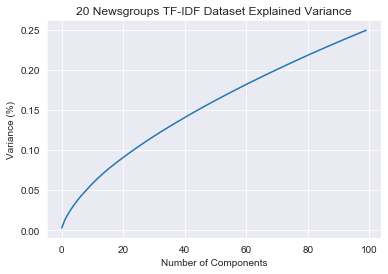

In [111]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(skl_decomp_obj.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('20 Newsgroups TF-IDF Dataset Explained Variance')
plt.show()

So, with 100 components we've managed to account for about a quarter of the variance in our data. This is after we brought it down from 1684 dimensions, so that's a lot of compression. Below I've run a gridsearchCV on a two logistic regression models, on with standard tf-idf data and one without it, to compare. 

In [102]:
logreg_pca = LogisticRegression()
logreg     = LogisticRegression()
logreg_param_grid = [{'penalty':['l1', 'l2']},
                 {'tol':[0.0001, 0.0005, 0.001]}]

# knn_pca.fit(pca_data, y_train)
# knn.fit(x_train_scaled, y_train)

grid_lsa_log = GridSearchCV(estimator=logreg_pca,
                        param_grid=logreg_param_grid, 
                        scoring='accuracy', cv=5,
                        n_jobs=6)

grid_log = GridSearchCV(estimator=logreg,
                        param_grid=logreg_param_grid, 
                        scoring='accuracy', cv=5,
                        n_jobs=6)


best_lsa_logreg = grid_lsa_log.fit(tfidf_lsa_data, y_train).best_estimator_
best_reg_logreg = grid_log.fit(tfidf_train_df, y_train).best_estimator_

In [103]:
print("ROC AUC of optimized Logistic Regression on validation data with principal components is :", best_lsa_logreg.score(tfidf_lsa_data, y_train))
print("ROC AUC of optimized Logistic Regression with standard validation data is :", best_reg_logreg.score(tfidf_train_df, y_train))

ROC AUC of optimized Logistic Regression on validation data with principal components is : 0.74076365564787
ROC AUC of optimized Logistic Regression with standard validation data is : 0.8975605444581934


The drop in performance is significant, but you can work this into an optimization pipeline and tweak the number of SVD components. Remember that we're only accounting for 25% of the variance -> that should put our accuracy result into perspective. 
Of course, this is multi-label classification, so it would be best to visualize this with a confusion matrix. 

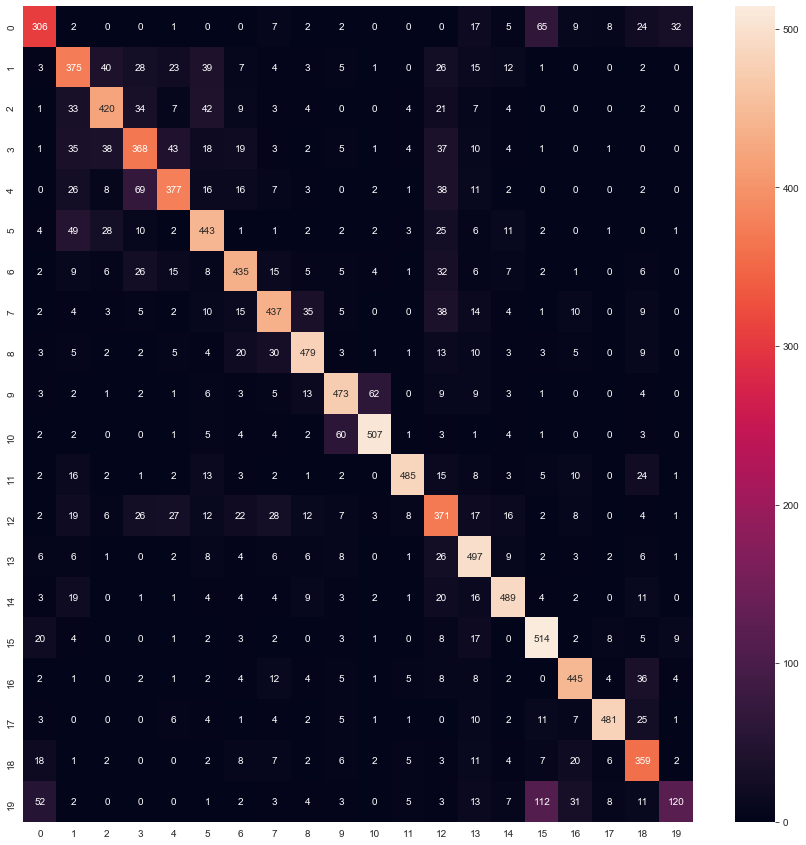

In [105]:
logreg_group_pred = best_lsa_logreg.predict(tfidf_lsa_data)
plt.figure(figsize=(15,15))
sns.heatmap(confusion_matrix(y_train, logreg_group_pred ), 
            annot=True, fmt='.4g');

In [31]:
from mpl_toolkits.mplot3d import Axes3D


I've included below some visualizations of the transformed data, just for the worth of the example code.

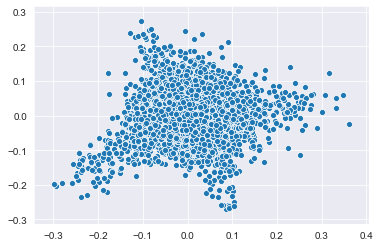

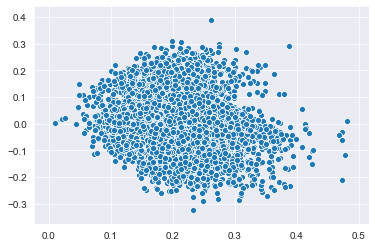

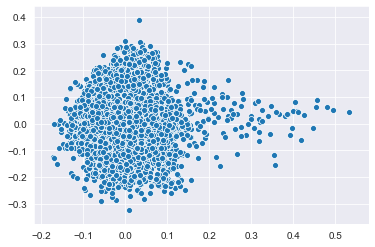

In [112]:
sns.scatterplot(tfidf_lsa_data[:,20], tfidf_lsa_data[:,25])
plt.show();
sns.scatterplot(tfidf_lsa_data[:,0], tfidf_lsa_data[:,2])
plt.show();
sns.scatterplot(tfidf_lsa_data[:,22], tfidf_lsa_data[:,2])
plt.show();


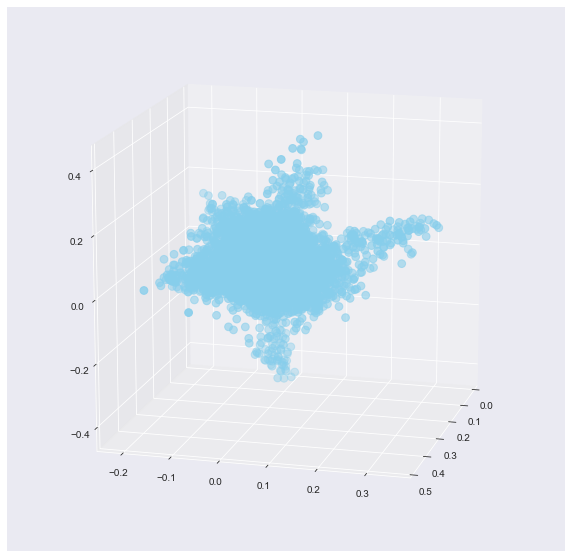

In [113]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tfidf_lsa_data[:,0], tfidf_lsa_data[:,15], tfidf_lsa_data[:,9], c='skyblue', s=60)
ax.view_init(15, 15)
plt.show()

## Clustering on LSA-processed data

We're implementing K-means clustering on our transformed data, starting with 20 clusters. 

In [114]:
kmeans = KMeans(n_clusters=20, max_iter=2000, algorithm = 'auto')
fitted_lsa_tfidf = kmeans.fit(tfidf_lsa_data)
predicted = kmeans.predict(tfidf_lsa_data)

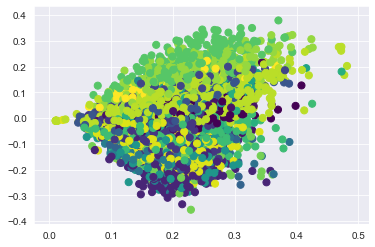

In [116]:
plt.scatter(tfidf_lsa_data[:, 0], tfidf_lsa_data[:, 1], c=predicted, s=50, cmap='viridis');


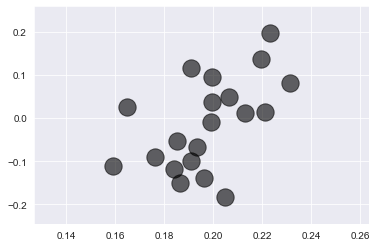

In [118]:
#and if we want to show the centers of our clusters ...
centers = fitted_lsa_tfidf.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

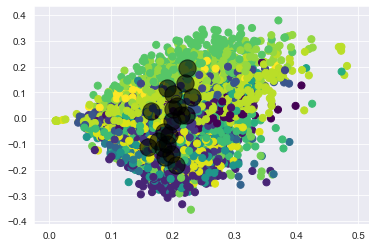

In [119]:
plt.scatter(tfidf_lsa_data[:, 0], tfidf_lsa_data[:, 1], c=predicted, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);


## K-means clustering on tf-idf data with no dimensionality reduction

In [123]:
# Please note that the get_top_features_cluster function is not finished! Although it is currently retrieving seemingly correct results, it is 
# using cluster labelling on decomposed data (be it via PCA or LSA) but then retrieving the features from the data that hasn't undergone decomposition.
# For the moment, I am performing clustering on the undecomposed data and then passing that in, but will return to fix this.
kmeans_tfidf = KMeans(n_clusters=20, max_iter=2000, algorithm = 'auto', random_state=42)
fitted_tfidf = kmeans_tfidf.fit(tfidf_train_sparse.toarray())
predicted_tfidf = kmeans_tfidf.predict(tfidf_train_sparse.toarray())


def get_top_features_cluster(tf_idf_array, prediction, n_feats, tf_idf_vectorizer):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizer.get_feature_names() #retrieving the columns of the original tfidf data - note this is in alphanumeric order
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = [f'features_cluster_{label}', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_array = tfidf_train_sparse.toarray(), 
                               prediction=predicted_tfidf, n_feats=10,
                              tf_idf_vectorizer = tfidf)

In [125]:
pd.concat([dfs[x] for x in range(len(dfs))], axis=1)

,features_cluster_0,score,features_cluster_1,score,features_cluster_2,score,features_cluster_3,score,features_cluster_4,score,...,features_cluster_15,score,features_cluster_16,score,features_cluster_17,score,features_cluster_18,score,features_cluster_19,score
0,people,0.055792,subject,0.039583,turkish,0.275642,gordon,0.426739,windows,0.233934,...,file,0.245877,fbi,0.213622,card,0.104292,jesus,0.097329,clinton,0.181167
1,would,0.052992,lines,0.039563,armenian,0.238081,banks,0.413562,window,0.115543,...,files,0.167633,koresh,0.156252,video,0.067227,christian,0.083752,tax,0.110789
2,one,0.044440,organization,0.039265,armenia,0.191882,surrender,0.138557,dos,0.092045,...,windows,0.067795,fire,0.093248,monitor,0.055546,christians,0.071731,president,0.091042
3,writes,0.039227,article,0.038195,turks,0.151927,pittsburgh,0.110798,win,0.038116,...,format,0.057571,children,0.073483,apple,0.054632,church,0.064561,health,0.061040
4,article,0.036502,writes,0.036756,soviet,0.082819,soon,0.107987,use,0.037134,...,program,0.054482,gas,0.072557,mac,0.050186,god,0.058298,bush,0.053726
5,like,0.034292,posting,0.034960,greek,0.077086,univ,0.104328,program,0.035962,...,directory,0.050968,waco,0.058214,mhz,0.045540,bible,0.056359,bill,0.046474
6,think,0.033795,host,0.034024,people,0.067060,science,0.086101,version,0.034223,...,ftp,0.047825,would,0.050158,bus,0.038189,people,0.051362,administration,0.040079
7,gun,0.029442,nntp,0.033646,muslim,0.052438,computer,0.079880,problem,0.032735,...,use,0.038155,writes,0.045408,mouse,0.038061,christ,0.050167,writes,0.036404
8,get,0.029228,university,0.029543,today,0.051593,reply,0.064498,application,0.032030,...,dos,0.035937,people,0.045259,system,0.034564,christianity,0.049621,would,0.036331
9,know,0.026455,distribution,0.022487,escape,0.045689,article,0.060480,running,0.031976,...,image,0.035693,government,0.043132,memory,0.033733,one,0.046693,care,0.035361


So above we have 20 clusters, each with the 10 most salient features. We re-plot these below as vertical bar plots for clarity... notice any trends?

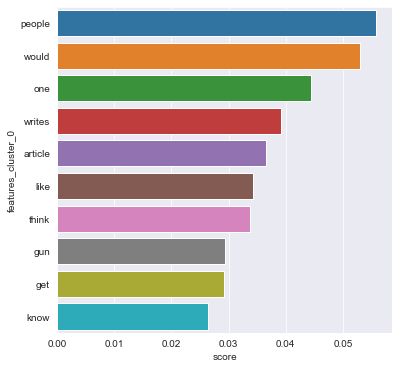

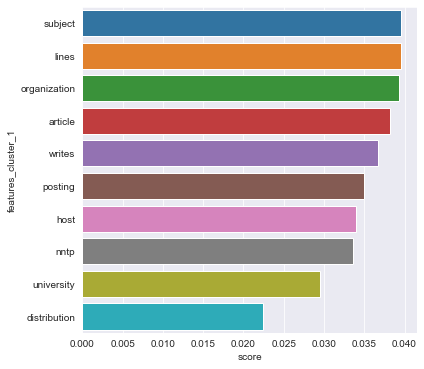

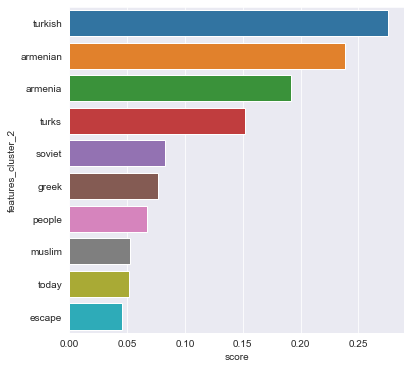

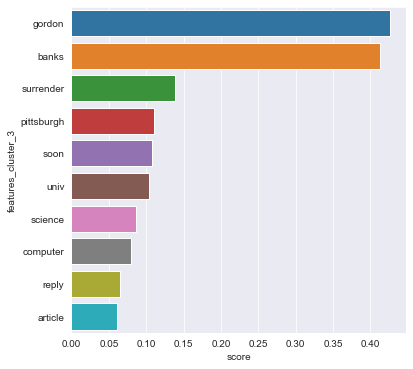

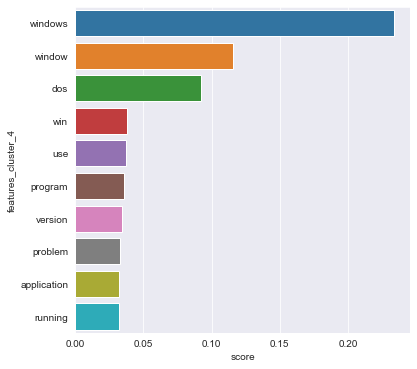

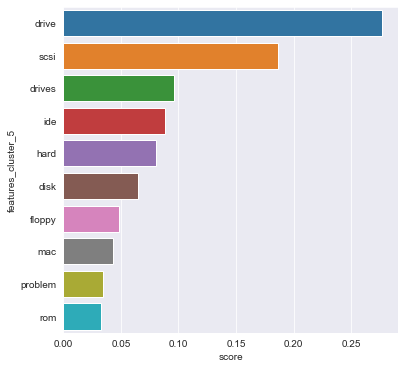

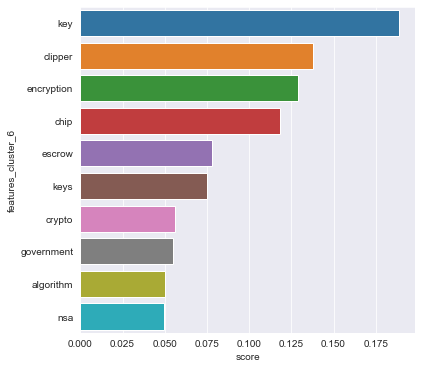

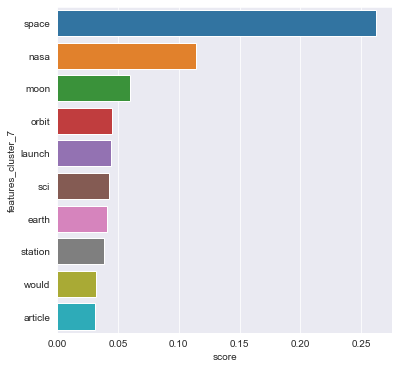

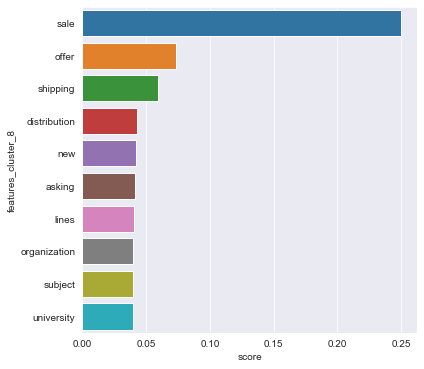

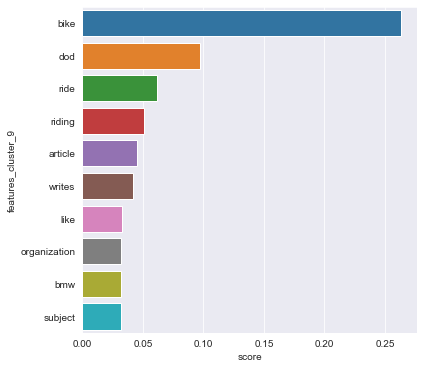

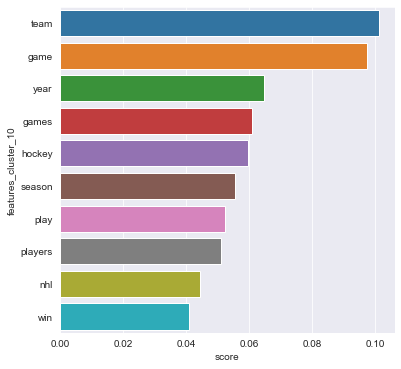

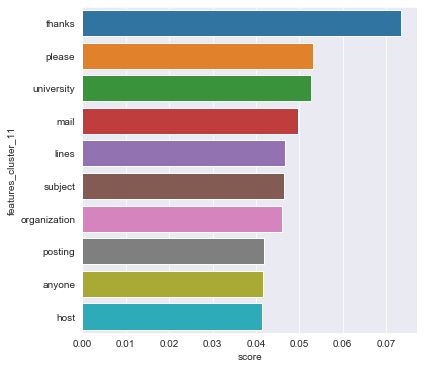

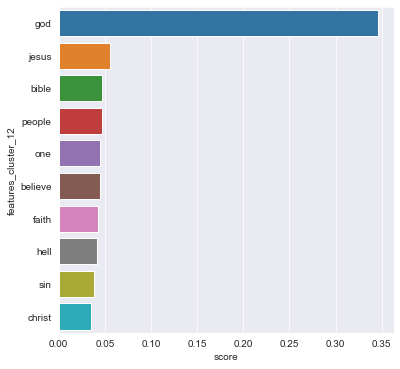

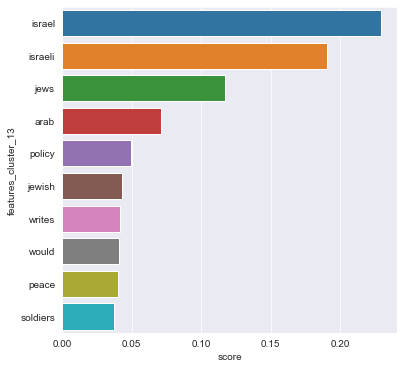

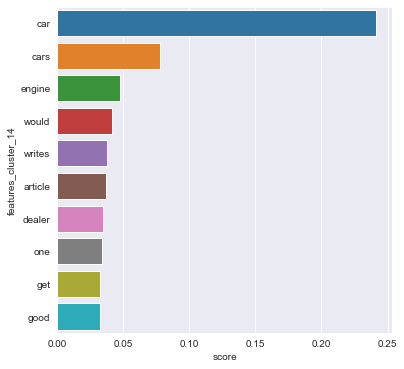

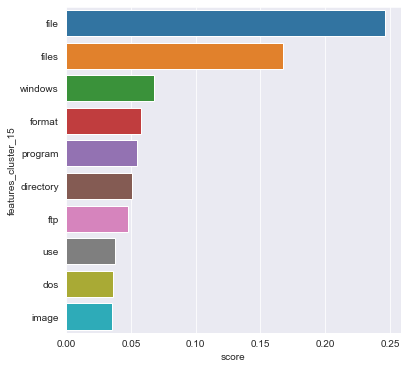

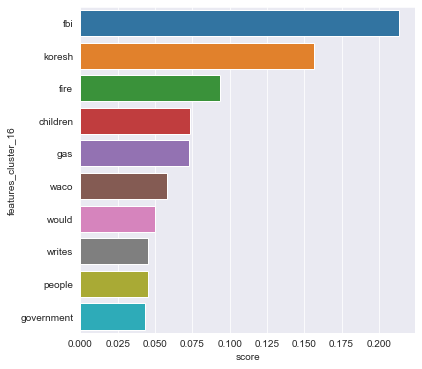

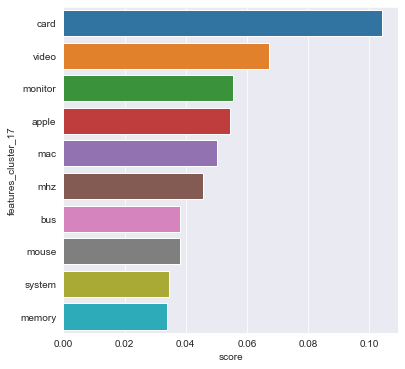

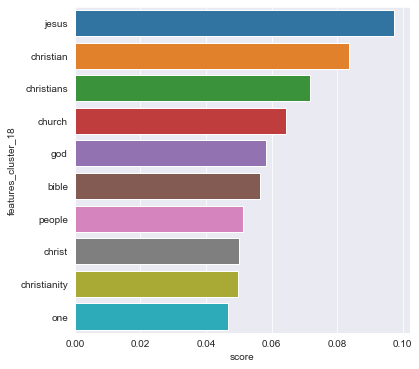

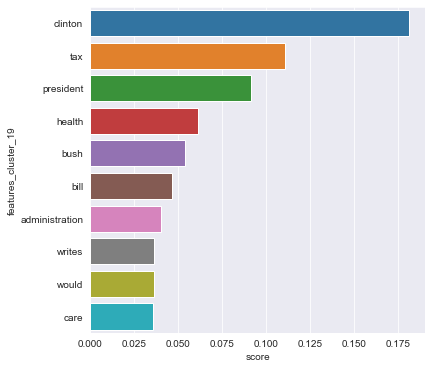

In [126]:
for i in range(len(dfs)):
    plt.figure(figsize=(6,6))
    sns.barplot(y=dfs[i][f'features_cluster_{i}'], x=dfs[i]['score'])
    plt.show();

And now for a reality check: with unsupervised learning tasks there is no ground-truth, no metric or target value to compare against. However, just to show people the potential of clustering finding some patterns, this dataset DOES have target values. There are 20 news categories. Although not all of the cluster features are clear, some are quite coherent, specifically clusters 4 ('space', 'nasa','moon'); 9 ('israel', 'arab', 'policy', 'peace'); 11 ('windows', 'dos', 'file', 'program'); 12, etc... 

Again, please remember that this will almost NEVER be this clean in real-life. There will be no ground truth, so interpretation will be far more subjective AND there is always a chance that what you're looking at is JUST NOISE. Sometimes there will be little to no insights to report.

I've printed the 20 Newsgroups description below - see how many of the news categories we managed to match just through clustering on tfidf data.

In [410]:
d = fetch_20newsgroups()['DESCR']
print(d)

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality 

In [127]:
silhouette_score(tfidf_train_df, labels=predicted)

0.015833539696081655

The silhouette score doesn't really tell us anything, except that our clusters are quite dispersed, which is to be expected with such sparse, text data. Nevertheless, we were able to gain insights, we just had to look at the top features ourselves. I hope you enjoyed this application of clustering to NLP. 